# Introduction

The purpose of this jupyter notebook is to clean and process the data from US_Recalls, to then be able to generate insights in a Power BI report

# Step 0: Import Libraries

The first task is to import the libraries used for this analysis and data cleaning/extraction; the first set of libraries includes os, pandas, missingno, and matplotlib.pyplot, which are commonly used for data analysis and visualization.

The second set of libraries, string, json and collections, are used for text manipulation tasks, such as cleaning and formatting text data.

The last set of libraries, re, nltk, and textblob, are commonly used in natural language processing (NLP) tasks, such as text classification, sentiment analysis, and language modeling.

In [1]:
#basic DS libraries
import os
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt 

#text manipulation
import string
import json
from collections import Counter

#NPL libraries
import re
import nltk
import textblob


# Step 1: Import Data

In [2]:
#Setting directory
dir_name = r'C:\Users\jlenehan\OneDrive - Intel Corporation\Documents\0 - Data Science\Projects\Auto Recalls\Auto-Recalls'
os.chdir(dir_name)

In [3]:
#Recalls Data
#csv_url = "https://datahub.transportation.gov/resource/6axg-epim.csv"

recalls_raw = pd.read_csv("Recalls_data.csv")

recalls_raw.head()

,Report Received Date,NHTSA ID,Recall Link,Manufacturer,Subject,Component,Mfr Campaign Number,Recall Type,Potentially Affected,Recall Description,Consequence Summary,Corrective Action,Park Outside Advisory,Do Not Drive Advisory
0,03/01/2023,23V133000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Forest River, Inc.",Entry Door Latch Failure,LATCHES/LOCKS/LINKAGES,310-1603,Vehicle,19.0,"Forest River, Inc. (Forest River) is recalling...",The inability to enter or exit the vehicle in ...,Dealers will inspect and replace the door latc...,No,No
1,03/01/2023,23V134000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Airstream, Inc.",Gas Valves May Fracture Causing Gas Leak,EQUIPMENT,NR (Not Reported),Vehicle,6827.0,Airstream Inc. (Airstream) is recalling certai...,A gas leak in the presence of an ignition sour...,Dealers will install a regulator support brack...,No,No
2,02/27/2023,23V130000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Tesla, Inc.",Second-Row Seat Frame May Be Improperly Secured,SEAT BELTS,SB-23-13-001,Vehicle,3470.0,"Tesla, Inc. (Tesla) is recalling certain 2022-...",A loose seat frame bolt may reduce the seat be...,Tesla Service Centers will inspect and tighten...,No,No
3,02/24/2023,23V126000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Prevost Car (US) Inc.,Fire Sensor May Falsely Detect Fires,EQUIPMENT,NR (Not Reported),Vehicle,555.0,Prevost Car (US) Inc. (Prevost) is recalling c...,The activation of the Automatic Fire Suppressi...,"Prevost will inspect the vehicles, install spa...",No,No
4,02/24/2023,23V124000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Gillig, LLC",Lower Control Arm May Fail,SUSPENSION,NR (Not Reported),Vehicle,349.0,"GILLIG, LLC (GILLIG) is recalling certain 2011...",Failure of a lower control arm can result in a...,The remedy is currently under development. As...,No,No


# Step 2: Describe Data

In [4]:
#Describe recalls dataset
print(recalls_raw.columns)
print(recalls_raw.info())
print(recalls_raw.describe())
print(recalls_raw.shape)

print(recalls_raw.head())

Index(['Report Received Date', 'NHTSA ID', 'Recall Link', 'Manufacturer',
       'Subject', 'Component', 'Mfr Campaign Number', 'Recall Type',
       'Potentially Affected', 'Recall Description', 'Consequence Summary',
       'Corrective Action', 'Park Outside Advisory ', 'Do Not Drive Advisory'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26730 entries, 0 to 26729
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Report Received Date    26730 non-null  object 
 1   NHTSA ID                26730 non-null  object 
 2   Recall Link             26730 non-null  object 
 3   Manufacturer            26730 non-null  object 
 4   Subject                 26730 non-null  object 
 5   Component               26730 non-null  object 
 6   Mfr Campaign Number     26701 non-null  object 
 7   Recall Type             26730 non-null  object 
 8   Potentially Affected    26688 non-n

Taking a quick look at all the unique values in each column using a for loop

In [5]:
#printing unique values

print('\nRecalls Data - Unique Values:')
for x in recalls_raw.columns:
    print(x+':')
    print(recalls_raw[x].unique())
    print(str(recalls_raw[x].nunique()) + str(' unique values'))


Recalls Data - Unique Values:
Report Received Date:
['03/01/2023' '02/27/2023' '02/24/2023' ... '09/29/1966' '09/19/1966'
 '01/19/1966']
9574 unique values
NHTSA ID:
['23V133000' '23V134000' '23V130000' ... '66V032001' '66V032003'
 '66V032004']
26730 unique values
Recall Link:
['Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=23V133000)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=23V134000)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=23V130000)' ...
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=66V032001)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=66V032003)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=66V032004)']
26730 unique values
Manufacturer:
['Forest River, Inc.' 'Airstream, Inc.' 'Tesla, Inc.' ... 'SS AUTOS, INC.'
 'ALGAR ENTERPRISES, INC.' 'ULTRA, INC.']
2939 unique values
Subject:
['Entry Door Latch Failure' 'Gas Valves May Fracture Causing Gas Leak'
 'Second-Row Seat Frame May Be Improperly Secured' ...
 'HEATER:UNKNOW

# Step 3: Clean Data

The missing data in the dataset can be visualised using the msno library; values in the dataset are first sorted by the "Report Received Date" column in ascending order, then a matrix plot of the missing values in the dataset can be plotted using the msno.matrix function. This plot shows the distribution of missing values across all columns of the dataset.

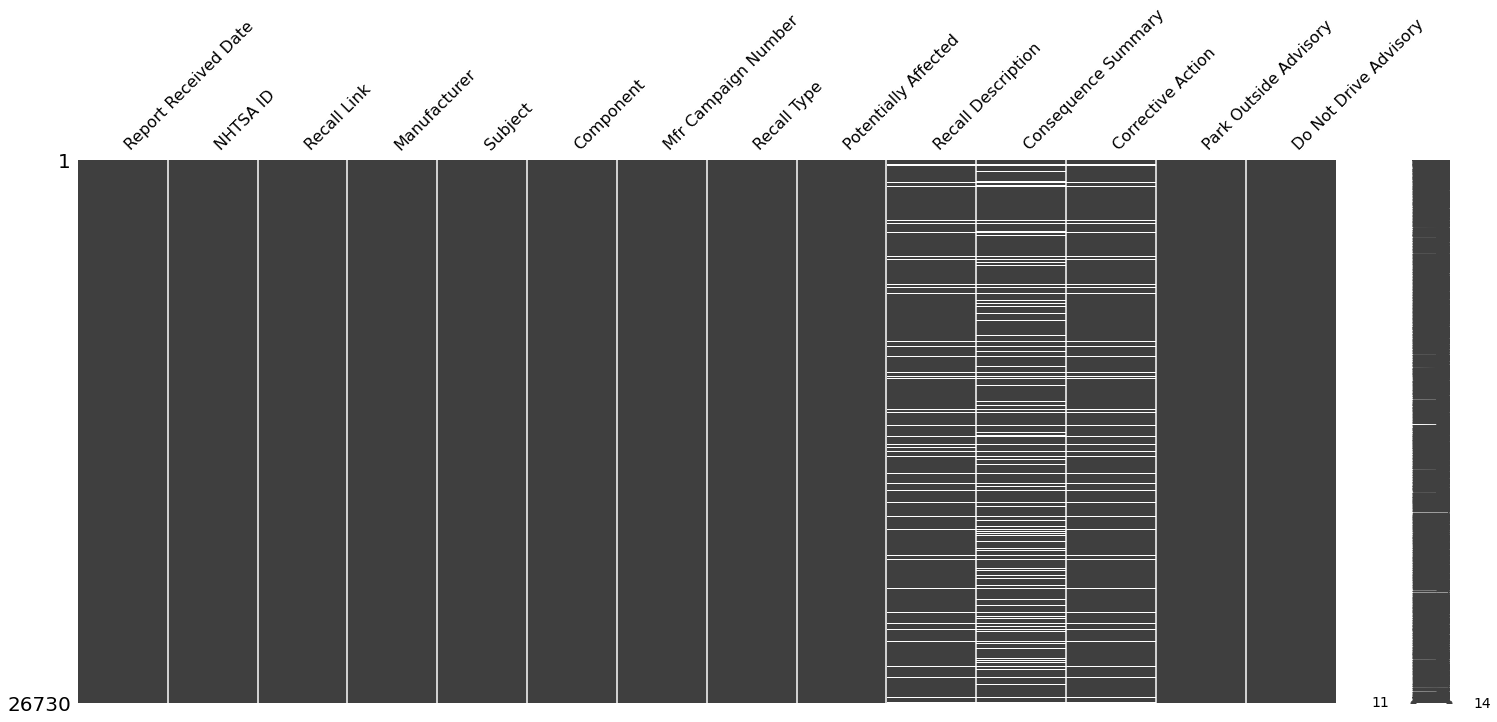

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26730 entries, 26671 to 4140
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Report Received Date    26730 non-null  object 
 1   NHTSA ID                26730 non-null  object 
 2   Recall Link             26730 non-null  object 
 3   Manufacturer            26730 non-null  object 
 4   Subject                 26730 non-null  object 
 5   Component               26730 non-null  object 
 6   Mfr Campaign Number     26701 non-null  object 
 7   Recall Type             26730 non-null  object 
 8   Potentially Affected    26688 non-null  float64
 9   Recall Description      24329 non-null  object 
 10  Consequence Summary     21842 non-null  object 
 11  Corrective Action       24342 non-null  object 
 12  Park Outside Advisory   26730 non-null  object 
 13  Do Not Drive Advisory   26730 non-null  object 
dtypes: float64(1), object(13)
memory us

In [6]:
#Visualising missing data

#Sorting values by report received date
recalls_raw = recalls_raw.sort_values(by='Report Received Date',ascending=True)

#plotting matrix of missing data
msno.matrix(recalls_raw)
plt.show()

#info of sorted data
print(recalls_raw.info())

In [7]:
#Separating recalls by potentially affected missing/complete
#affected_missing = recalls[recalls['Potentially Affected'].isna()]
#affected_complete = recalls[~recalls['Potentially Affected'].isna()]

#print(affected_missing.describe())
#print(affected_complete.describe())

This visualisation is further refined once the rows with no "Potentially Affected" units are scrubbed from the dataset:

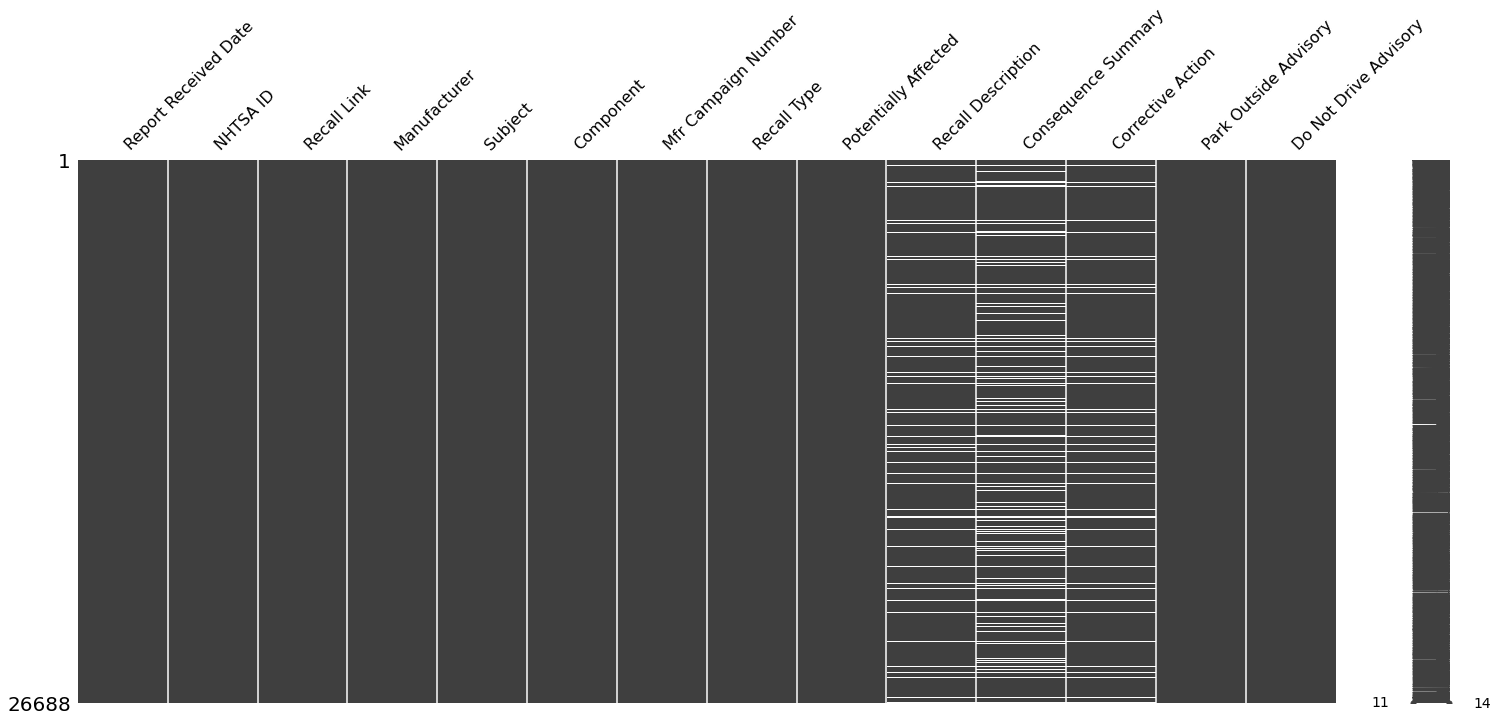

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26688 entries, 26671 to 4140
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Report Received Date    26688 non-null  object 
 1   NHTSA ID                26688 non-null  object 
 2   Recall Link             26688 non-null  object 
 3   Manufacturer            26688 non-null  object 
 4   Subject                 26688 non-null  object 
 5   Component               26688 non-null  object 
 6   Mfr Campaign Number     26659 non-null  object 
 7   Recall Type             26688 non-null  object 
 8   Potentially Affected    26688 non-null  float64
 9   Recall Description      24287 non-null  object 
 10  Consequence Summary     21800 non-null  object 
 11  Corrective Action       24300 non-null  object 
 12  Park Outside Advisory   26688 non-null  object 
 13  Do Not Drive Advisory   26688 non-null  object 
dtypes: float64(1), object(13)
memory us

In [8]:
#dropping rows with missing 'Potentially Affected' data - irrelevant for analysis
recalls_raw = recalls_raw.dropna(subset = ['Potentially Affected'])

#plotting matrix of missing data
msno.matrix(recalls_raw)
plt.show()

#info of sorted data
print(recalls_raw.info())

We can see that only the columns 'Mfr Campaign Number', 'Recall Description', 'Consequence Summary', and 'Corrective Action' now have missing data; this can be cleaned up using the fillna function, subbing in "Missing_Info" for any blank entries.

Once this is done, we can see from the msno matric that we now have a dataset with no blank entries:

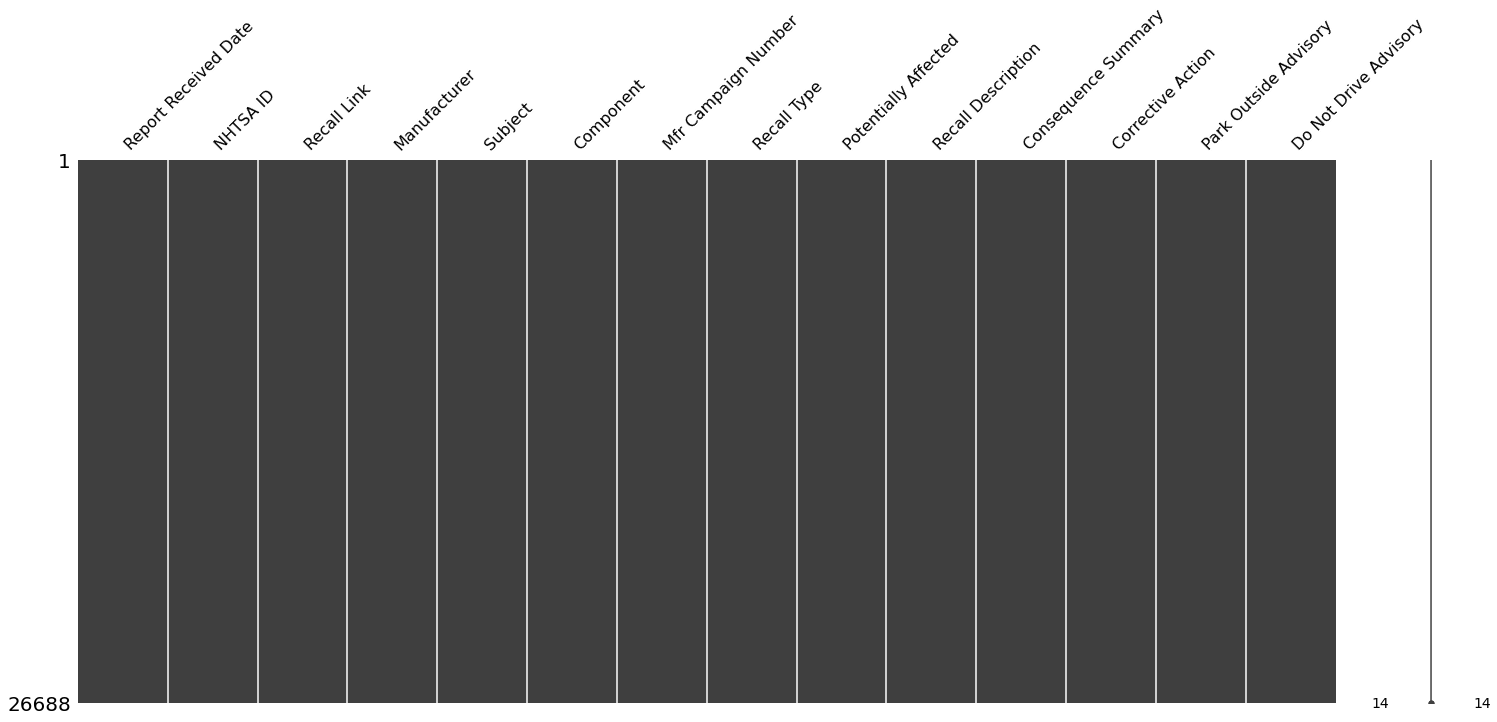

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26688 entries, 26671 to 4140
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Report Received Date    26688 non-null  object 
 1   NHTSA ID                26688 non-null  object 
 2   Recall Link             26688 non-null  object 
 3   Manufacturer            26688 non-null  object 
 4   Subject                 26688 non-null  object 
 5   Component               26688 non-null  object 
 6   Mfr Campaign Number     26688 non-null  object 
 7   Recall Type             26688 non-null  object 
 8   Potentially Affected    26688 non-null  float64
 9   Recall Description      26688 non-null  object 
 10  Consequence Summary     26688 non-null  object 
 11  Corrective Action       26688 non-null  object 
 12  Park Outside Advisory   26688 non-null  object 
 13  Do Not Drive Advisory   26688 non-null  object 
dtypes: float64(1), object(13)
memory us

In [9]:
#filling in missing text data in text columns 
#text_cols = recalls_raw[['Recall Description','Consequence Summary','Corrective Action']]
recalls_raw = recalls_raw.fillna(value = 'Missing_Info')

#plotting matrix of missing data
msno.matrix(recalls_raw)
plt.show()

#info of sorted data
print(recalls_raw.info())

## NLP Column Analysis: Corrective Action  

Next we prepare for some natural language processing (NLP) work on the "Corrective Actions" column, by first defining the stopwords to ignore during the language processing, and then the tokenising and lemmatising functions to pick out keywords in the text.   

The stopwords file is contained in the text file 'excluded_words.txt', also contained in this folder; the WhitespaceTokenizer function is a tokeniser that uses whitespace as a delimiter to break up text into individual words or tokens, while WordNetLemmatizer is a tool for reducing inflected words to their base or root form (the "lemma"). 

Unfortunately a trial of different lemmatising functions has shown that it doesn't pick up all inflections in the text, so further processing will be done in later stages, to swap out inflections and synonyms using a dictionary.

In [10]:
#NLP prep - defining NLTK functions

#reading in stopwords txt file to list
stopwords_file = 'excluded_words.txt'
stopwords_filepath = os.path.join(dir_name, stopwords_file)

with open(stopwords_filepath) as file:
    stopwords = set(file.read().split())

#defining tokenising and lemmatising functions from NLTK
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text) if w.lower() not in stopwords]


Along with this we define supplementary functions for text processing, to remove numbers, replace inflections or synonyms based on an inflection dictionary, filter out keywords, and remove duplicate words in a column:

In [11]:
#removing numbers in the analysis column
def remove_num(text):
    return re.sub(r'\d+', '', text)

#function to replace inflections
def replace_inflections(string):
    for inflection, replacement in inflect_dict.items():
        string = string.replace(inflection, replacement)
    return string

#function to remove words not found in the keywords list
def filter_keywords(row, wordlist):
    # split the row into individual words
    words = row.split()
    # create a new list with only the words in the word_list
    filtered_words = [word for word in words if word in wordlist]
    # join the filtered words back together into a string
    filtered_row = ' '.join(filtered_words)
    return filtered_row

#function to remove duplicate words in the classification column
def remove_duplicate_words(text):
    words = text.split()
    unique_words = list(set(words))
    return ' '.join(unique_words)

Following this we clean the data, lemmatise the text, and convert the text to lowercase. The resulting lemmatised text is stored in a new column called "CA Lemm".

In [12]:
#creating new column in df for NLP analysis

#punctuation list
punct = '[' + string.punctuation + ']'

#removing punctuation and lemmatising column
recalls_raw['CA Lemm'] = recalls_raw['Corrective Action'].str.replace(punct,'',regex=True).apply(lemmatize_text) 

#converting column type to lowercase string for further analysis
recalls_raw['CA Lemm'] = recalls_raw['CA Lemm'].apply(str).apply(str.lower).str.replace(punct,'',regex=True)

The counter function gives us an idea of the most common tokens found in the text, printing the count of instances for each word:

In [13]:
Counter(" ".join(recalls_raw["CA Lemm"]).split()).most_common(20)

[('recall', 19759),
 ('service', 11985),
 ('replace', 10547),
 ('notify', 9065),
 ('inspect', 4826),
 ('notification', 4714),
 ('install', 3576),
 ('vehicles', 3105),
 ('remedy', 2961),
 ('safety', 2784),
 ('repair', 2748),
 ('vehicle', 2576),
 ('missinginfo', 2388),
 ('mailed', 2368),
 ('letter', 2317),
 ('brake', 2027),
 ('receive', 1936),
 ('replaced', 1827),
 ('affected', 1804),
 ('fuel', 1735)]

We can see that the lemmatising function hasn't picked up all inflections (for example, the words 'notification' and replaced', which should have been converted to 'notify' and 'replace' respectively). Subsequently we can define an inflection dictionary (also included in the folder) to catch these stray inflections and convert them to the format we need for analysis:

In [14]:
#postprocessing lemmatised words to reduce variations with word inflections
with open('inflect_dict.txt','r') as f:
    inflect_dict = json.load(f)

#applying to column
recalls_raw["CA Lemm"] = recalls_raw["CA Lemm"].apply(replace_inflections)

Applying the remove_num function lets us strip out all numbers in the text: 

In [15]:
#applying both functions to the Corrective Action Analysis column
recalls_raw['CA Lemm'] = recalls_raw['CA Lemm'].apply(remove_num)

In [16]:
#counting number of rows in the corrective action column that contain at least one keyword


match_count = 0

for row in recalls_raw["CA Lemm"]:
    for word in keywords:
        if word in row:
            match_count +=1
            break

print(match_count)
print(keywords)

25927
['service', 'notify', 'replace', 'refund', 'inspect', 'install', 'repair', 'missinginfo', 'remove', 'reroute', 'relocate', 'reprogram', 'modify', 'remove', 'reroute', 'relocate', 'reprogram', 'modify', 'retrofit', 'adjust']


Now we filter the 'CA Lemm' column to only keep words contained in the keywords, by first 

In [20]:
# Open keywords file for reading
with open("keywords.txt", "r") as f:
    # Load the list from the file
    keywords = json.load(f)

#applying keywords filter to classification column
recalls_raw['CA Keywords'] = recalls_raw['CA Lemm'].apply(lambda w: filter_keywords(w, keywords))

#removing duplicate words in the entries
recalls_raw['CA Keywords'] = recalls_raw['CA Keywords'].apply(remove_duplicate_words)

# sort the values alphabetically for each row
recalls_raw['CA Keywords'] = recalls_raw['CA Keywords'].apply(lambda w: ' '.join(sorted(w.split())))

#print result
print(recalls_raw.head())

#print number of unique classifiers
print(recalls_raw['CA Keywords'].nunique())

      Report Received Date   NHTSA ID  \
26671           01/01/1967  67V011000   
26670           01/01/1967  67V010000   
25789           01/01/1972  72V025000   
24363           01/01/1977  77V011000   
24362           01/01/1977  77V012000   

                                             Recall Link  \
26671  Go to Recall (https://www.nhtsa.gov/recalls?nh...   
26670  Go to Recall (https://www.nhtsa.gov/recalls?nh...   
25789  Go to Recall (https://www.nhtsa.gov/recalls?nh...   
24363  Go to Recall (https://www.nhtsa.gov/recalls?nh...   
24362  Go to Recall (https://www.nhtsa.gov/recalls?nh...   

                                   Manufacturer  \
26671                Nissan North America, Inc.   
26670                       General Motors, LLC   
25789  INTERNATIONAL TRUCK & ENGINE CORPORATION   
24363                         Mack Trucks, Inc.   
24362                       General Motors, LLC   

                                        Subject                  Component  \
26671  

The majority of the lemmatised rows in 'CA Lemm' now contains at least one keyword, or 'missing info' (24926 against the total 26574 rows). Let's subset the remaining rows which don't contain these keywords to determine the most common lemmatised words in these instances. 

In [17]:
def subset_no_keywords(wordlist, data):
    return [row for row in data if all(word not in row for word in wordlist)]

recalls_no_keyword = subset_no_keywords(keywords,recalls_raw['CA Lemm']) 
print(recalls_no_keyword)

['cut center floor support tube forward prevent puncturing fuel tank rear impact collision', 'torque suspect fasteners proper specifications', 'pamphlet sent consumers', 'electronic fuel control bypass valve redesigned prevent loss throttle control pace sysems operating cruise control', 'correct wiring cruise control', 'reflash electronic control unit safety recall february   ducati ', 'vehicles possessions', 'corrected information plates supplied manufacturer cost', 'correct certification labels involved vehicles cost', 'purge throttle cable internally trapped water', 'drill  inch hole cost', 'international braun corporation doorway lift fixed please e braun corporation  international ', 'affected vehicles brought dealerships remedied factory vehicles retailed', 'wiring connections auxiliary fuel pump soldered cost', 'fill holes underside vehicle floor silicone caulk', 'american emergency vehicles ricon correct wheelchair lifts please e ricon  american emergency vehicles ', 'forest ri

In [18]:
Counter(" ".join(recalls_no_keyword).split()).most_common(20)

[('ricon', 278),
 ('correct', 218),
 ('please', 159),
 ('e', 152),
 ('recall', 144),
 ('wheelchair', 140),
 ('lifts', 124),
 ('air', 74),
 ('pressure', 67),
 ('vehicles', 55),
 ('valve', 53),
 ('brake', 51),
 ('system', 42),
 ('corrected', 39),
 ('relief', 39),
 ('remedy', 38),
 ('dryer', 38),
 ('prevent', 37),
 ('bus', 36),
 ('safety', 35)]

In [19]:
#applying new inflections to column
recalls_raw["CA Lemm"] = recalls_raw["CA Lemm"].apply(replace_inflections)

match_count = 0

for row in recalls_raw["CA Lemm"]:
    for word in keywords:
        if word in row:
            match_count +=1
            break

print(match_count)

25927


## Export Data for Power BI Analysis

In [21]:
Counter(" ".join(recalls_raw["CA Keywords"]).split()).most_common(80)

[('replace', 14296),
 ('notify', 13779),
 ('service', 10895),
 ('inspect', 4784),
 ('install', 4698),
 ('repair', 2417),
 ('missinginfo', 2388),
 ('modify', 1508),
 ('remove', 658),
 ('reprogram', 294),
 ('reroute', 287),
 ('refund', 218),
 ('retrofit', 112)]

In [22]:
#tabulating CA data
group_CA_Class = recalls_raw['CA Keywords'].value_counts()

#printing 20 most common
print(group_CA_Class)

notify replace service                             3669
replace                                            3367
missinginfo                                        2388
notify replace                                     1700
install                                            1398
                                                   ... 
inspect remove repair service                         1
inspect install repair replace service                1
notify refund remove service                          1
modify notify replace retrofit service                1
inspect notify repair replace reprogram service       1
Name: CA Keywords, Length: 271, dtype: int64


In [23]:
#exporting to csv for PBI report
recalls_raw.to_csv('pbi_recalls_data.csv',index=False)